In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data = pd.read_csv('pollution_new.csv')
data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,1/2/2010 0:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1,1/2/2010 1:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2,1/2/2010 2:00,159,-11,-5.0,1021.0,SE,3.57,0,0
3,1/2/2010 3:00,181,-7,-5.0,1022.0,SE,5.36,1,0
4,1/2/2010 4:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
series = np.array(data['pollution'])
time = np.array(range(len(data['pollution'])))

In [12]:
split_size = 365 * 24 * 4

time_train = time[: split_size]
x_train = series[: split_size]

time_valid = time[split_size: ]
x_valid = series[split_size: ]

In [13]:
def plot_series(time, series, sign = '-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], sign)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

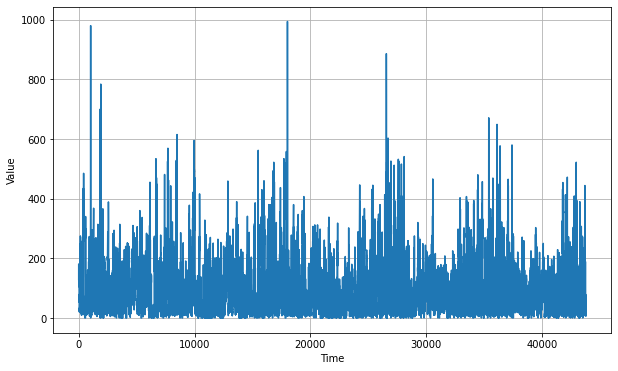

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [17]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[: -1], w[-1: ]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [29]:
window_size = 64
batch_size = 256
shuffle_buffer = 1000

training = window_dataset(x_train, window_size, batch_size, shuffle_buffer)

tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch/20))

model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['mae'])

history = model.fit(training, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
137/137 [==============================] - 3s 19ms/step - loss: 15534.0547 - mae: 90.5854 - lr: 1.0000e-06
Epoch 2/100
137/137 [==============================] - 3s 19ms/step - loss: 15201.5547 - mae: 89.3796 - lr: 1.1220e-06
Epoch 3/100
137/137 [==============================] - 3s 19ms/step - loss: 14846.5947 - mae: 88.0810 - lr: 1.2589e-06
Epoch 4/100
137/137 [==============================] - 3s 20ms/step - loss: 14467.3154 - mae: 86.6803 - lr: 1.4125e-06
Epoch 5/100
137/137 [==============================] - 3s 19ms/step - loss: 14064.4736 - mae: 85.1750 - lr: 1.5849e-06
Epoch 6/100
137/137 [==============================] - 3s 20ms/step - loss: 13639.2168 - mae: 83.5728 - lr: 1.7783e-06
Epoch 7/100
137/137 [==============================] - 3s 19ms/step - loss: 13192.9238 - mae: 81.8736 - lr: 1.9953e-06
Epoch 8/100
137/137 [==============================] - 3s 20ms/step - loss: 12728.4395 - mae: 80.0852 - lr: 2.2387e-06
Epoch 9/100
137/137 [===========================

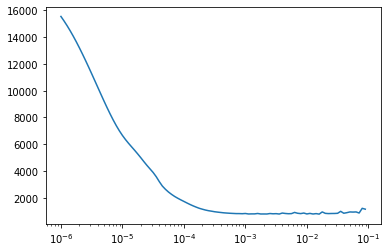

In [33]:
plt.semilogx(history.history['lr'], history.history['loss'])
# plt.axis([1e-8, 1e-4, 0, 60])

In [37]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
    
forecast = forecast[split_size - window_size: ]
results = np.array(forecast)[:, 0, 0]

In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

93.806915